In [1]:
import gzip
import theano
import cPickle
import matplotlib
import numpy as np
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline


with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = cPickle.load(f)
    

def shared_dataset(data_xy):
    data_x, data_y = data_xy
    return theano.shared(data_x), theano.shared(data_y)


test_set_x, test_set_y = shared_dataset(test_set)
valid_set_x, valid_set_y = shared_dataset(valid_set)
train_set_x, train_set_y = shared_dataset(train_set)
batch_size = 500
train_data_set_size = len(train_set[0])

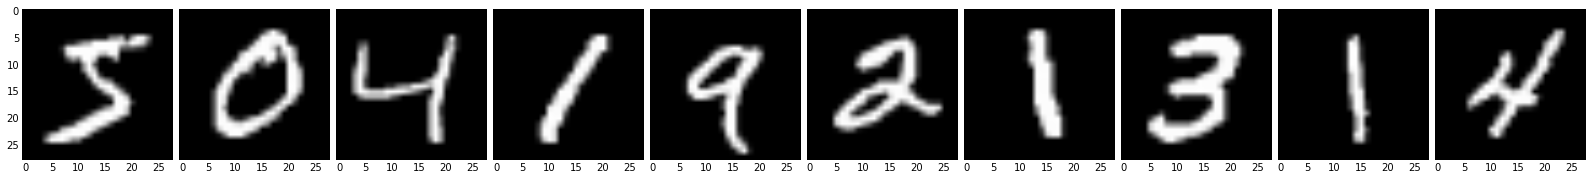

In [2]:
fig = plt.figure(1, (28., 28.))
grid = ImageGrid(fig, 111, nrows_ncols = (1, 10), axes_pad=0.1)

for c in range(10):
    image_array = train_set[0][c].reshape((28, 28))
    grid[c].imshow(image_array, cmap=plt.cm.gray)

In [3]:
from theano import tensor as T


class LogisticRegresion(object):
    def __init__(self, w_init):
        self.W = theano.shared(w_init())
        
    def get_output_expr(self, input_expr):
        pre_softmax_expr = T.dot(input_expr, self.W)
        return T.nnet.softmax(pre_softmax_expr)

    def get_parameters(self):
        return [self.W]
    

def get_sgd_updates(cost, params, lr=0.05):
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        updates.append([p, p - lr * g])
    return updates

In [8]:
w_init = lambda: np.random.randn(784, 10) * 0.01
lr_model = LogisticRegresion(w_init)
X = T.fmatrix()
y = T.lvector()
batch_index = T.iscalar()
py_x = lr_model.get_output_expr(X)
y_pred = T.argmax(py_x, axis=1)
cost = T.mean(T.nnet.categorical_crossentropy(py_x, y))

updates = get_sgd_updates(cost, lr_model.get_parameters())
train = theano.function(inputs=[batch_index], outputs=cost, updates=updates, 
                        givens={X: train_set_x[batch_index * batch_size:(batch_index + 1) * batch_size],
                                y: train_set_y[batch_index * batch_size:(batch_index + 1) * batch_size]})
val = theano.function(inputs=[], outputs=cost, givens={X: valid_set_x, y: valid_set_y})
get_prediction_accuracy = theano.function(inputs=[], outputs=T.mean(T.eq(y_pred, y)), givens={X: test_set_x, y: test_set_y})

for i in range(100):
    for index in range(train_data_set_size / batch_size):
        cost = train(index)
    if i % 10 == 0:
        print i, get_prediction_accuracy(), val()
print get_prediction_accuracy(), val()        

0 0.8493 0.764609290036
10 0.902 0.360322486856
20 0.9091 0.325791550264
30 0.9133 0.310654133393
40 0.9164 0.301727357208
50 0.9175 0.295706471579
60 0.9182 0.291315552504
70 0.9193 0.287943274451
80 0.9194 0.285255662118
90 0.9192 0.283053280809
0.9198 0.281380020911


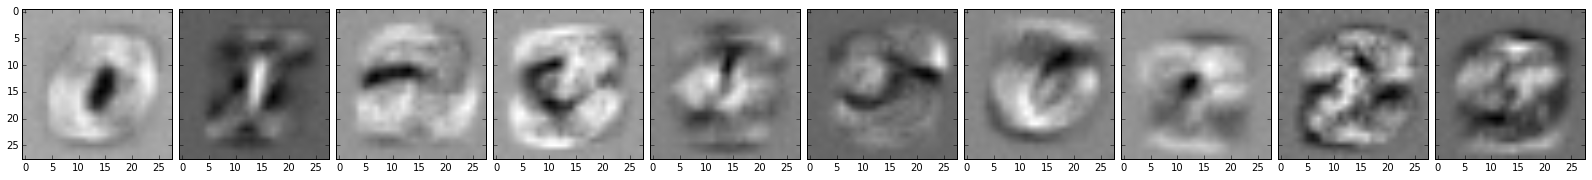

In [9]:
fig = plt.figure(1, (28., 28.))
grid = ImageGrid(fig, 111, nrows_ncols = (1, 10), axes_pad=0.1)

for i in range(10):
    image_array = lr_model.W.get_value()[:, i].reshape((28, 28))
    grid[i].imshow(image_array, cmap=plt.cm.gray)